In [ ]:
! mkdir -pv data/images
! wget https://github.com/gulvarol/grocerydataset/releases/download/1.0/GroceryDataset_part1.tar.gz
! wget https://github.com/gulvarol/grocerydataset/releases/download/1.0/GroceryDataset_part2.tar.gz
! tar xvf GroceryDataset_part1.tar.gz
! tar xvf GroceryDataset_part2.tar.gz

Streaming output truncated to the last 5000 lines.
ProductImagesFromShelves/0/C1_P02_N2_S2_1.JPG_1088_1632_340_584.png
BrandImagesFromShelves/6/C1_P08_N3_S3_1.JPG_1904_892_216_368.png
ProductImagesFromShelves/0/C2_P06_N1_S4_1.JPG_1172_928_164_220.png
ProductImagesFromShelves/0/C4_P02_N2_S3_1.JPG_340_332_164_228.png
ProductImagesFromShelves/0/C4_P08_N1_S2_1.JPG_2556_620_244_392.png
ProductImagesFromShelves/0/C1_P08_N3_S4_2.JPG_2820_920_200_340.png
ProductImagesFromShelves/2/C4_P03_N1_S4_1.JPG_1476_656_168_240.png
BrandImagesFromShelves/2/C4_P03_N2_S3_2.JPG_332_296_192_264.png
ProductImagesFromShelves/0/C3_P07_N4_S2_1.JPG_3760_504_412_564.png
ProductImagesFromShelves/0/C1_P08_N1_S4_1.JPG_1976_1436_212_324.png
ProductImagesFromShelves/0/C3_P07_N2_S3_1.JPG_2720_1096_292_408.png
ProductImagesFromShelves/0/C3_P03_N1_S5_1.JPG_644_2140_152_276.png
ProductImagesFromShelves/0/C1_P03_N1_S2_1.JPG_2772_1120_220_320.png
ProductImagesFromShelves/0/C1_P02_N2_S4_1.JPG_464_1400_264_380.png
BrandImagesFr

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **STEP 1 Naive Bayes**

In [ ]:
import cv2
import pandas as pd
from matplotlib import pyplot as plt
import os
import numpy as np
from sklearn.model_selection import train_test_split
%matplotlib inline

In [ ]:
data_path = 'data/'
# we'll use data from two folders
shelf_images = 'ShelfImages/'
product_images = 'ProductImagesFromShelves/'

In [ ]:
# let's get all shelves photo data from ShelfImages
jpg_files = [f for f in os.listdir(f'{shelf_images}') if f.endswith('JPG')]
photos_df = pd.DataFrame([[f, f[:6], f[7:14]] for f in jpg_files], 
                         columns=['file', 'shelf_id', 'planogram_id'])
photos_df.head()

file shelf_id planogram_id
0  C4_P08_N1_S2_1.JPG   C4_P08      N1_S2_1
1  C1_P10_N1_S5_1.JPG   C1_P10      N1_S5_1
2  C3_P02_N2_S3_1.JPG   C3_P02      N2_S3_1
3  C2_P08_N2_S3_1.JPG   C2_P08      N2_S3_1
4  C2_P02_N1_S4_1.JPG   C2_P02      N1_S4_1

In [ ]:
# let's get products on shelves photo from ProductImagesFromShelves
products_df = pd.DataFrame(
    [[f[:18], f[:6], f[7:14], i, *map(int, f[19:-4].split('_'))] 
     
     for i in range(11) 
     for f in os.listdir(f'{product_images}{i}') if f.endswith('png')],
    columns=['file', 'shelf_id', 'planogram_id', 
             'category', 'xmin', 'ymin', 'w', 'h'])
# convert from width height to xmax, ymax
products_df['xmax'] = products_df['xmin'] + products_df['w']
products_df['ymax'] = products_df['ymin'] + products_df['h']
products_df.head()

file shelf_id planogram_id  category  ...    w    h  xmax  ymax
0  C3_P02_N2_S4_1.JPG   C3_P02      N2_S4_1         0  ...  200  280   680  1140
1  C3_P05_N3_S3_1.JPG   C3_P05      N3_S3_1         0  ...  308  436  3908  1520
2  C3_P03_N4_S2_1.JPG   C3_P03      N4_S2_1         0  ...  268  380  4160  1668
3  C4_P08_N1_S5_2.JPG   C4_P08      N1_S5_2         0  ...  136  204   488  1256
4  C2_P04_N1_S5_1.JPG   C2_P04      N1_S5_1         0  ...  136  176  1120  1720

[5 rows x 10 columns]

In [ ]:
# get distinct shelves
shelves = list(set(photos_df['shelf_id'].values))
# use train_test_split from sklearn
shelves_train, shelves_validation, _, _ = train_test_split(
    shelves, shelves, test_size=0.3, random_state=6)
# mark all records in data frames with is_train flag
def is_train(shelf_id): return shelf_id in shelves_train
photos_df['is_train'] = photos_df.shelf_id.apply(is_train)
products_df['is_train'] = products_df.shelf_id.apply(is_train)

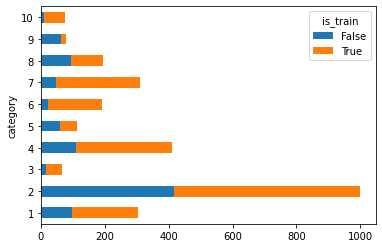

In [ ]:
df = products_df[products_df.category != 0].\
         groupby(['category', 'is_train'])['category'].\
         count().unstack('is_train').fillna(0)
df.plot(kind='barh', stacked=True)

In [ ]:
# save to pkl
photos_df.to_pickle(f'{data_path}photos.pkl')
products_df.to_pickle(f'{data_path}products.pkl')

In [ ]:
# function to display shelf photo with rectangled products
def draw_shelf_photo(file):
    file_products_df = products_df[products_df.file == file]
    coordinates = file_products_df[['xmin', 'ymin', 'xmax', 'ymax']].values
    im = cv2.imread(f'{shelf_images}{file}')
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)    
    for xmin, ymin, xmax, ymax in coordinates:
        cv2.rectangle(im, (xmin, ymin), (xmax, ymax), (0, 255, 0), 5)
    plt.imshow(im)

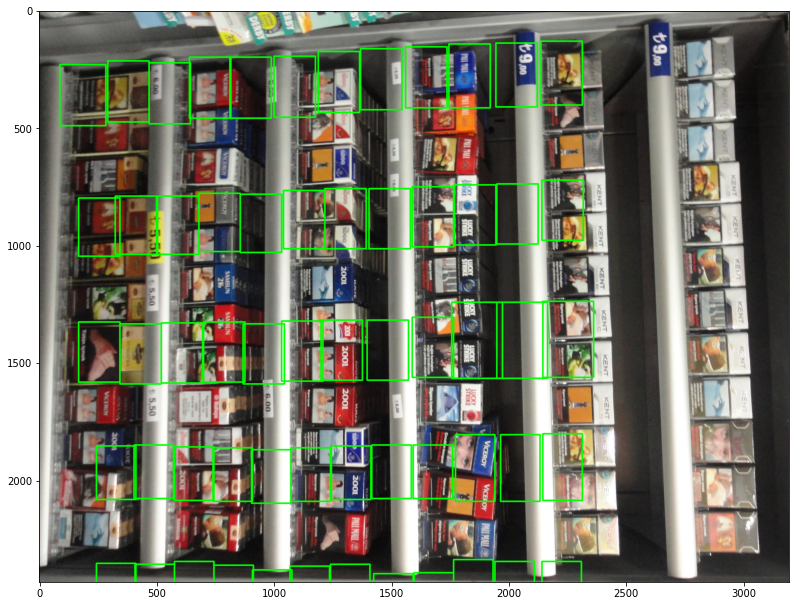

In [ ]:
# draw one photo to check our data
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
draw_shelf_photo('C3_P07_N1_S6_1.JPG')

## **STEP2**

In [ ]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import pandas as pd
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras import backend as K
from tensorflow.keras.utils import to_categorical
import tensorflow as tf


%matplotlib inline

In [ ]:
# path to data and shelves images
data_path = 'data/'
shelf_images = 'ShelfImages/'

In [ ]:
# load data from previous step
photos_df = pd.read_pickle(f'{data_path}photos.pkl')
products_df =  pd.read_pickle(f'{data_path}products.pkl')

In [ ]:
# neural networks work with input of fixed size, so we need to resize our
# packs images to the chosen size. The size is some kind of metaparameter and 
# you should try different variants. Logically, the bigger size you select,
# the better performace you'll have. Unfortunatelly it is not true, because 
# of over fitting. The more parameters your neural network have, the easier it
# became over fitted
num_classes = 10
SHAPE_WIDTH = 80
SHAPE_HEIGHT = 120

In [ ]:
# resize pack to fixed size SHAPE_WIDTH x SHAPE_HEIGHT
def resize_pack(pack):
    fx_ratio = SHAPE_WIDTH / pack.shape[1]
    fy_ratio = SHAPE_HEIGHT / pack.shape[0]    
    pack = cv2.resize(pack, (0, 0), fx=fx_ratio, fy=fy_ratio)
    return pack[0:SHAPE_HEIGHT, 0:SHAPE_WIDTH]

In [ ]:
# x - image, y - class, f - is_train flag
x, y, f = [], [], []
for file, is_train in photos_df[['file', 'is_train']].values:
    photo_rects = products_df[products_df.file == file]
    rects_data = photo_rects[['category', 'xmin', 'ymin', 'xmax', 'ymax']]
    im = cv2.imread(f'{shelf_images}{file}')
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    for category, xmin, ymin, xmax, ymax in rects_data.values:
        if category == 0:
            continue
        pack = resize_pack(np.array(im[ymin:ymax, xmin:xmax]))
        x.append(pack)
        f.append(is_train)
        y.append(category - 1)

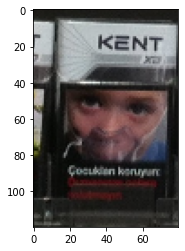

In [ ]:
# display one SHAPE_WIDTH x SHAPE_HEIGHT resized pack image, 
# it is hard to recognize category with our eyes, let's see
# how neural network will do the job
plt.imshow(x[50])

In [ ]:
# let's split the data to train/validation sets based on our is_train flag
x = np.array(x)
y = np.array(y)
f = np.array(f)
x_train, x_validation, y_train, y_validation = x[f], x[~f], y[f], y[~f]
# save validation images
x_validation_images = x_validation

In [ ]:
# convert y_train and y_validation to one-hot arrays
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_validation = tf.keras.utils.to_categorical(y_validation, num_classes)

In [ ]:
# normalize x_train, x_validation
x_train = x_train.astype('float32')
x_validation = x_validation.astype('float32')
x_train /= 255
x_validation /= 255

In [ ]:
# let's see what do we have
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_validation.shape[0], 'validation samples')

x_train shape: (1811, 120, 80, 3)
y_train shape: (1811, 10)
1811 train samples
933 validation samples


In [ ]:
# let's build our ResNet CNN. We don't do any significant changes to keras example
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 5:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr
 
 
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))
 
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x
 
 
def resnet_v1(input_shape, depth, num_classes=10):
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)
 
    inputs = Input(shape=x_train.shape[1:])
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2
 
    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)
 
    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model
 
n = 3
version = 1
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2
model_type = 'ResNet%dv%d' % (depth, version)
 
model = resnet_v1(input_shape=x_train.shape[1:], depth=depth, num_classes=num_classes)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)), metrics=['accuracy'])

Learning rate:  0.001


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

In [ ]:
# let's run training process, 20 epochs is enough
batch_size = 50
epochs = 20
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_validation, y_validation),
                    epochs=epochs, verbose=1, workers=4, 
                    callbacks=[LearningRateScheduler(lr_schedule)])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
Learning rate:  0.001
37/37 [==============================] - 58s 205ms/step - loss: 1.9492 - accuracy: 0.4857 - val_loss: 10.0103 - val_accuracy: 0.0525
Epoch 2/20
Learning rate:  0.001
37/37 [==============================] - 5s 122ms/step - loss: 0.6273 - accuracy: 0.8603 - val_loss: 2.3529 - val_accuracy: 0.5370
Epoch 3/20
Learning rate:  0.001
37/37 [==============================] - 5s 122ms/step - loss: 0.4402 - accuracy: 0.9153 - val_loss: 2.2132 - val_accuracy: 0.6109
Epoch 4/20
Learning rate:  0.001
37/37 [==============================] - 5s 124ms/step - loss: 0.3859 - accuracy: 0.9234 - val_loss: 1.7523 - val_accuracy: 0.6699
Epoch 5/20
Learning rate:  0.001
37/37 [==============================] - 5s 124ms/step - loss: 0.3807 - accuracy: 0.9383 - val_loss: 1.9708 - val_accuracy: 0.6967
Epoch 6/20
Learning rate:  0.001
37/37 [==============================] - 5s 132ms/step - loss: 0.3087 - accuracy: 0.9534 - val_loss: 1.6470 - val_accuracy: 0.7353
Epoch 7/20
Lea

In [ ]:
# let's see our model architecture and how may trainable params does it have
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 80, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 120, 80, 16)  448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 120, 80, 16)  64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 120, 80, 16)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

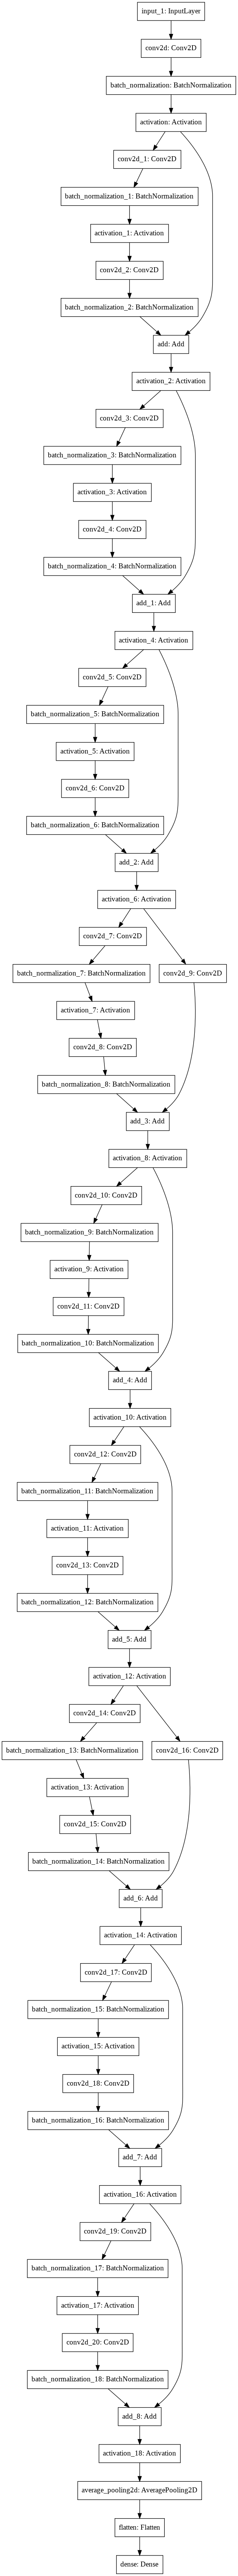

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
# let's estimate our result
scores = model.evaluate(x_validation, y_validation, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

30/30 [==============================] - 1s 21ms/step - loss: 0.6277 - accuracy: 0.9057
Test loss: 0.62772536277771
Test accuracy: 0.9056805968284607


In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# let's draw confusion matrix to check classes recognition performance
y_validation_cls = np.argmax(y_validation, axis=1)
y_validation_predict = model.predict(x_validation)
y_validation_predict_cls = np.argmax(y_validation_predict, axis=1)

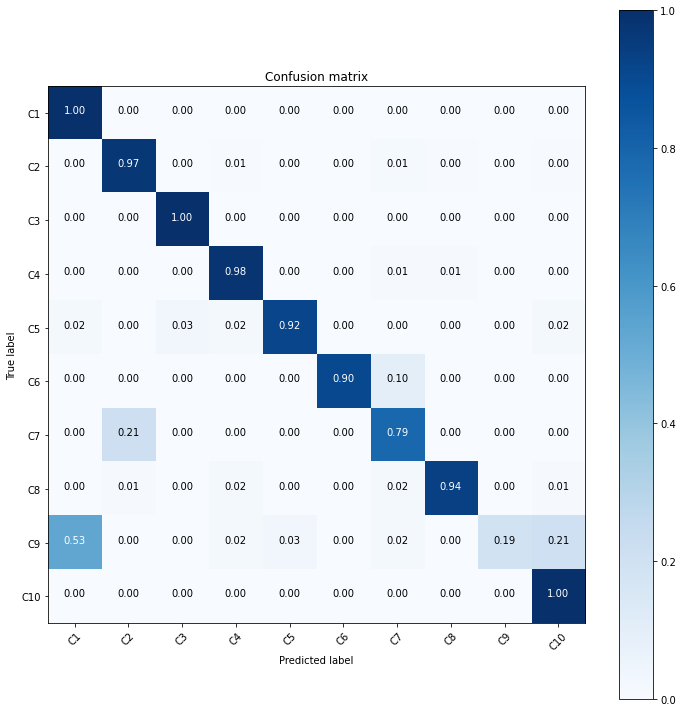

In [ ]:
fig = plt.gcf()
fig.set_size_inches(10, 10)
cnf_matrix = confusion_matrix(y_validation_cls, y_validation_predict_cls)
plot_confusion_matrix(cnf_matrix, [f'C{i+1}' for i in range(num_classes)], 
                      title='Confusion matrix', normalize=True)

In [ ]:
power = np.array([y_validation_predict[i][y_validation_predict_cls[i]] 
                  for i in range(len(y_validation_predict_cls))])


margin = 5
width = num_classes * SHAPE_WIDTH + (num_classes - 1) * margin
height = num_classes * SHAPE_HEIGHT + (num_classes - 1) * margin
confusion_image = np.zeros((height, width, 3), dtype='i')
for i in range(num_classes):
    for j in range(num_classes):
        flags = [(y_validation_cls == i) & (y_validation_predict_cls == j)]
        if not np.any(flags):
            continue
        max_cell_power = np.max(power[flags])
        index = np.argmax(flags & (power == max_cell_power))
        ymin, xmin = (SHAPE_HEIGHT+margin) * i, (SHAPE_WIDTH+margin) * j
        ymax, xmax = ymin + SHAPE_HEIGHT, xmin + SHAPE_WIDTH
        confusion_image[ymin:ymax, xmin:xmax, :] = x_validation_images[index]
        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


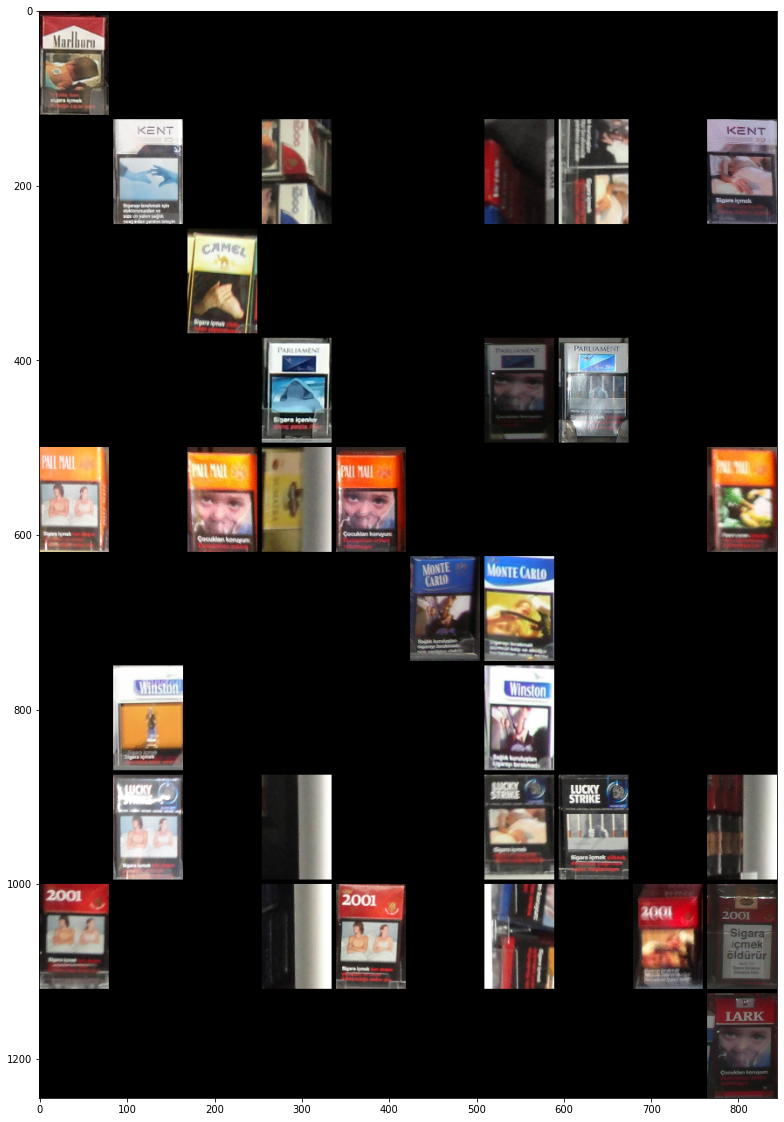

In [ ]:
fig = plt.gcf()
fig.set_size_inches(20, 20)
plt.imshow(confusion_image)

# **STEP 3**

In [ ]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

!pip install object-detection-0.1

     |████████████████████████████████| 808kB 35.5MB/s 


In [ ]:
import numpy as np
import tensorflow as tf
import cv2
import pandas as pd

from collections import defaultdict
from matplotlib import pyplot as plt

# This is needed since the notebook is stored in the object_detection folder.
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
import tensorflow.compat.v2 as tf
#tf.disable_v2_behavior()

if tf.__version__ < '1.4.0':
    raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')

In [ ]:
# This is needed to display the images.
%matplotlib inline

In [ ]:
# paths to main folders: with frozen graph, with classes labels, 
# with all shelves images and with data
PATH_TO_MODEL = 'frozen_inference_graph.pb'
PATH_TO_LABELS = 'pack.pbtxt'
PATH_TO_IMAGES = 'ShelfImages/'
PATH_TO_DATA = 'data/'
NUM_CLASSES = 1

In [ ]:
# load photos dataframe to get all evaluation images names
photos = pd.read_pickle(f'{PATH_TO_DATA}photos.pkl')
photos = photos[~photos.is_train]
photos.head()

file shelf_id planogram_id  is_train
0   C4_P08_N1_S2_1.JPG   C4_P08      N1_S2_1     False
10  C1_P01_N3_S2_1.JPG   C1_P01      N3_S2_1     False
11  C2_P06_N2_S4_2.JPG   C2_P06      N2_S4_2     False
14  C4_P07_N2_S3_1.JPG   C4_P07      N2_S3_1     False
15  C2_P06_N1_S2_1.JPG   C2_P06      N1_S2_1     False

In [ ]:
!pip install -U "tensorflow>=2.0"

Requirement already up-to-date: tensorflow>=2.0 in /usr/local/lib/python3.7/dist-packages (2.5.0)


In [ ]:
# load frozen graph
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.compat.v1.GraphDef()
    #od_graph_def  = tf.function()
    with tf.compat.v1.io.gfile.GFile(PATH_TO_MODEL, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [ ]:
# let's write function that executes detection
def run_inference_for_single_image(image, image_tensor, sess, tensor_dict):
    # Run inference
    expanded_dims = np.expand_dims(image, 0)
    output_dict = sess.run(tensor_dict, feed_dict={image_tensor: expanded_dims})
    # all outputs are float32 numpy arrays, so convert types as appropriate
    output_dict['num_detections'] = int(output_dict['num_detections'][0])
    output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
    output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
    output_dict['detection_scores'] = output_dict['detection_scores'][0]
    return output_dict

In [ ]:
# it is useful to be able to run inference not only on the whole image,
# but also on its parts
# cutoff - minimum detection scrore needed to take box
def run_inference_for_image_part(image_tensor, sess, tensor_dict, 
                                 image, cutoff, ax0, ay0, ax1, ay1):
    boxes = []
    im = image[ay0:ay1, ax0:ax1]
    h, w, c = im.shape
    output_dict = run_inference_for_single_image(im, image_tensor, sess, tensor_dict)
    for i in range(100):
        if output_dict['detection_scores'][i] < cutoff:
            break
        y0, x0, y1, x1, score = *output_dict['detection_boxes'][i], \
                                output_dict['detection_scores'][i]
        x0, y0, x1, y1, score = int(x0*w), int(y0*h), \
                                int(x1*w), int(y1*h), \
                                int(score * 100)
        boxes.append((x0+ax0, y0+ay0, x1+ax0, y1+ay0, score))
    return boxes

In [ ]:
# additional helper function to work not with coordinates but with percents
def run_inference_for_image_part_pcnt(image_tensor, sess, tensor_dict, 
                                 image, cutoff, p_ax0, p_ay0, p_ax1, p_ay1):
    h, w, c = image.shape
    max_x, max_y = w-1, h-1
    return run_inference_for_image_part(
                                image_tensor, sess, tensor_dict, 
                                image, cutoff, 
                                int(p_ax0*max_x), int(p_ay0*max_y), 
                                int(p_ax1*max_x), int(p_ay1*max_y))

In [ ]:
# function to display image with bounding boxes
def display_image_with_boxes(image, boxes, p_x0=0, p_y0=0, p_x1=1, p_y1=1):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for x0, y0, x1, y1, score in boxes:
        image = cv2.rectangle(image, (x0, y0), (x1, y1), (0,255,0), 5)
    if p_x0 != 0 or p_y0 !=0 or p_x1 != 1 or p_y1 != 1:
        h, w, c = image.shape
        max_x, max_y = w-1, h-1
        image = cv2.rectangle(image, 
                              (int(p_x0*max_x), int(p_y0*max_y)), 
                              (int(p_x1*max_x), int(p_y1*max_y)), (0,0,255), 5)
    plt.figure(figsize=(14, 14))
    plt.imshow(image)

In [ ]:
# initializations function
def initialize_graph():
    ops = tf.compat.v1.get_default_graph().get_operations()
    all_tensor_names = {output.name
                        for op in ops
                        for output in op.outputs}
    tensor_dict = {}
    for key in ['num_detections', 'detection_boxes',
                'detection_scores', 'detection_classes',
                'detection_masks']:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
            tensor_dict[key] = tf.compat.v1.get_default_graph().get_tensor_by_name(tensor_name)
    image_tensor = tf.compat.v1.get_default_graph().get_tensor_by_name('image_tensor:0')
    return image_tensor, tensor_dict

# starting function for inference
def do_inference_and_display(file, cutoff, p_x0=0, p_y0=0, p_x1=1, p_y1=1):
    with detection_graph.as_default():
        with tf.compat.v1.Session() as sess:
            image_tensor, tensor_dict = initialize_graph()
            image = cv2.imread(f'{PATH_TO_IMAGES}{file}')
            h, w, c = image.shape
            boxes = run_inference_for_image_part_pcnt(
                image_tensor, sess, tensor_dict, image, cutoff, p_x0, p_y0, p_x1, p_y1)
            display_image_with_boxes(image, boxes, p_x0, p_y0, p_x1, p_y1)


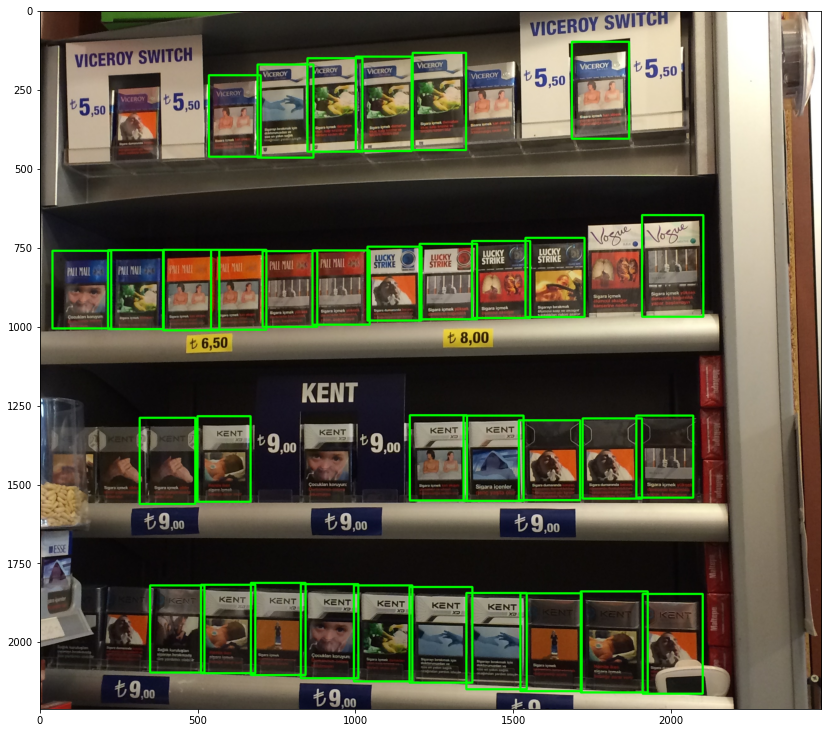

In [ ]:
# to save time let's start with really hard image
do_inference_and_display('C1_P10_N1_S4_1.JPG', 0.5)
# it works not bad, but not with 100% quality

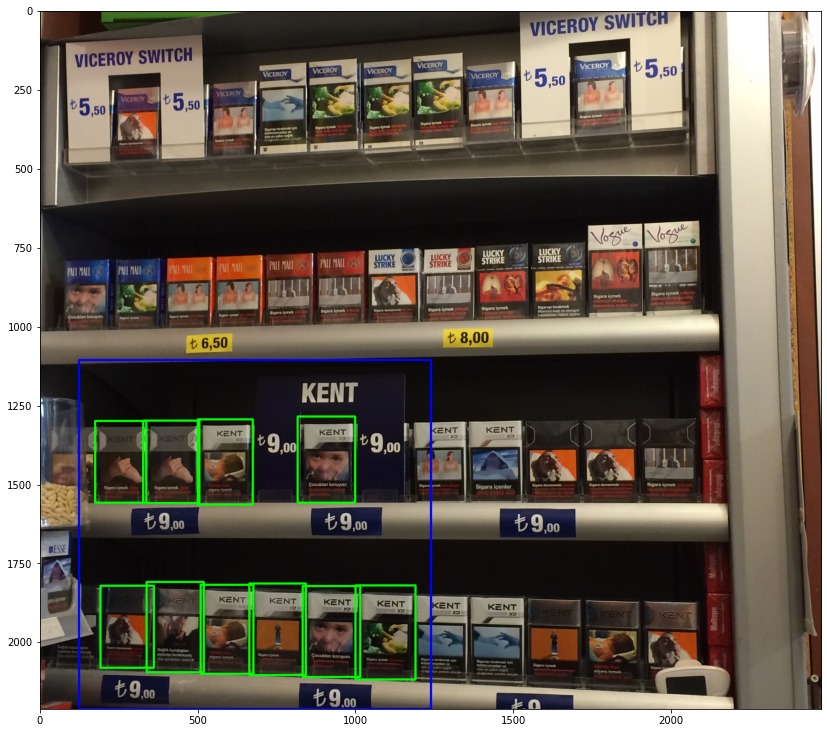

In [ ]:
# let's try do detection on small part of image
# let's also increase the cutoff rate
do_inference_and_display('C1_P10_N1_S4_1.JPG', 0.9, 0.05, 0.5, 0.5, 1)
# it works perfect for small parts of image, it gives an idea for
# sliding window approach